RSNL not converging ... do some tests on why

# suspect 1: use full cov matrix?

In [ ]:
import os
import pickle as pkl
import jax.random as random
from flowjax.bijections import RationalQuadraticSpline  # type: ignore
from flowjax.distributions import StandardNormal  # type: ignore
from flowjax.flows import CouplingFlow  # type: ignore
from flowjax.train.data_fit import fit_to_data  # type: ignore
from jax._src.prng import PRNGKeyArray  # for typing
from numpyro.infer import MCMC, NUTS  # type: ignore

import jax.numpy as jnp
import numpy as np
import torch

from mm_sbi_review.examples.earthquake import (
    earthquake_sim_fn_4_param,
    sum_fn,
    early_return,
)
from mm_sbi_review.scripts.utils import (
    download_file,
    extract_tar_gz,
    combine_ascii_files,
)

import pandas as pd
from shapely.geometry import Polygon
import geopandas as gpd
from numpyro.distributions import Gamma, Uniform, Independent

In [ ]:
np.random.seed(123)
torch.manual_seed(321)
# true_mu = 1.58e-06
# true_alpha = 1.3
# true_k = 0.0025
# true_c = 0.003
# true_p = 1.05  # or 0.66 or 1.05

# true_mu = 2e-05
# true_k = 0.2
# true_c = 0.5
# true_p = 1.5

# true_params = {'log10_mu': np.log10(true_mu), 'log10_k0': np.log10(true_k),
#             #    'a': true_alpha,
#                 'log10_c': np.log10(true_c), 'rho': true_p}
# TODO: first - set up simulator to take in parameters
# TODO: SNPE
# TODO: Priors
# beta = 2.302585092994046
# beta = 2.4
url = "https://scedc.caltech.edu/ftp/catalogs/SCEC_DC/SCEDC_catalogs.tar.gz"
local_filename = "SCEDC_catalogs.tar.gz"
extract_path = "./"

# Download and extract the file
download_file(url, local_filename)
extract_tar_gz(local_filename, extract_path)
combine_ascii_files("./raw")
raw_catalog = pd.read_csv("raw/SCEDC_catalog.csv")
raw_catalog["time"] = pd.to_datetime(raw_catalog["time"])
raw_catalog = raw_catalog.sort_values(by="time")
raw_catalog = raw_catalog[["time", "longitude", "latitude", "magnitude"]].dropna()
raw_catalog.reset_index(drop=False, inplace=True)

polygon_coords = np.load("../data/SCEDC_shape.npy")

poly = Polygon(polygon_coords)
gdf = gpd.GeoDataFrame(
    raw_catalog,
    geometry=gpd.points_from_xy(raw_catalog.latitude, raw_catalog.longitude),
)

catalog = gdf[gdf.intersects(poly)].copy()
catalog.drop("geometry", axis=1, inplace=True)
len_trunc_x = len(catalog)
print("Removed", len(raw_catalog) - len_trunc_x, "events outside polygon")

# filter events within timewindow
auxiliary_start = "1985-01-01 00:00:00"
test_nll_end = "2014-01-11 00:00:00"
catalog = catalog[catalog["time"] >= auxiliary_start]
catalog = catalog[catalog["time"] < test_nll_end]
len_trunc_t = len(catalog)
print("Removed", len_trunc_x - len_trunc_t, "events outside timewindow")

M_cut = 3.0
catalog = catalog[catalog["magnitude"] >= M_cut]
len_trunc_m = len(catalog)
print("Removed", len_trunc_t - len_trunc_m, "events below Mcut")

x_obs = sum_fn(catalog)

Downloaded SCEDC_catalogs.tar.gz
Extracted to ./
final file shape:  (890615, 12)
Merged dataset saved successfully as a CSV file.
Removed 0 events outside polygon
Removed 365809 events outside timewindow
Removed 514852 events below Mcut
Kvals[0]:  0.09765982507406056


In [574]:
x_sims_all.shape

(3000, 39)

In [575]:
valid_idx

In [ ]:
with open("../res/earthquake_4_param/thetas_all_round_1.pkl", "rb") as f:
    thetas_all = pkl.load(f)

with open("../res/earthquake_4_param/x_sims_all_round_1.pkl", "rb") as f:
    x_sims_all = pkl.load(f)

valid_idx = None
# valid_idx = jnp.where(x_sims_all[:, 1] > 0, True, False)

reduce_summ_idx = None
# reduce_summ_idx = [0, 1, 2, 3, 4, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
# reduce_summ_idx = [0, 1, 2, 3, 4, 23, 29, 35, 37]
# reduce_summ_idx = [0, 1, 2, 3, 4, 37, 38]
reduce_summ_idx = jnp.arange(0, 23)
if reduce_summ_idx is not None:
    x_sims_all = jnp.array(x_sims_all)[:, reduce_summ_idx]
    x_obs = x_obs[reduce_summ_idx]

if valid_idx is not None:
    x_sims_all = x_sims_all[valid_idx, :]
    thetas_all = jnp.array(thetas_all)[valid_idx, :]


# TODO! DOING HERE WHILE SAVED IS NOT LOGGED
for i in range(1, 5):
    x_sims_all = x_sims_all.at[:, i].set(jnp.log(x_sims_all[:, i]))
    # replace nans with -10  TODO! TEMP PROOF OF CONCEPT
    idx = jnp.isnan(x_sims_all[:, i])
    rng_key, sub_key = random.split(rng_key)
    x_sims_all = x_sims_all.at[idx, i].set(
        -10 + random.normal(sub_key, shape=(jnp.sum(idx),))
    )
    rng_key, sub_key = random.split(rng_key)
    idx = jnp.isinf(x_sims_all[:, i])
    rng_key, sub_key = random.split(rng_key)
    x_sims_all = x_sims_all.at[idx, i].set(
        -10 + random.normal(sub_key, shape=(jnp.sum(idx),))
    )
    x_obs[i] = np.log(x_obs[i])
    # TODO! LOG RIPLEYS AS WELL?

# standardize the data
theta_dims = 4
summary_dims = x_sims_all.shape[1]

standardisation_params = {
    "theta_mean": jnp.empty(theta_dims),
    "theta_std": jnp.empty(theta_dims),
    "x_sims_mean": jnp.empty(summary_dims),
    "x_sims_std": jnp.empty(summary_dims),
}

# standardise simulated summaries
standardisation_params["x_sims_mean"] = jnp.mean(x_sims_all, axis=0)
standardisation_params["x_sims_std"] = jnp.std(x_sims_all, axis=0)
x_sims_all_standardised = (
    x_sims_all - standardisation_params["x_sims_mean"]
) / standardisation_params["x_sims_std"]
x_obs_standard = (
    x_obs - standardisation_params["x_sims_mean"]
) / standardisation_params["x_sims_std"]

# standardise parameters
standardisation_params["theta_mean"] = jnp.mean(thetas_all, axis=0)
standardisation_params["theta_std"] = jnp.std(thetas_all, axis=0)

thetas_all_standardised = (
    thetas_all - standardisation_params["theta_mean"]
) / standardisation_params["theta_std"]
x_obs_standard = (x_obs - x_sims_all.mean(axis=0)) / x_sims_all.std(axis=0)
x_sims_all_standardised.shape

x_sims_all[:20, 1]

/var/folders/_z/ms2f3nmn0bb7wk4py9_pz7900000gp/T/ipykernel_74882/367527543.py:35: RuntimeWarning: invalid value encountered in log
  x_obs[i] = np.log(x_obs[i])


Array([ -6.8341436 , -10.795464  ,  -8.4949465 ,  -3.2791028 ,
        -0.92865855,  -0.4238978 ,  -5.158153  ,  -2.1856253 ,
        -0.21641281, -11.087809  ,  -3.737739  ,  -9.757305  ,
        -2.9109147 ,   0.71894914,  -8.533529  , -10.7404175 ,
       -10.428791  ,  -1.7822218 ,  -6.802395  ,  -1.3388367 ],      dtype=float32)

In [603]:
x_sims_all.shape

(3000, 23)

In [ ]:
with open("../res/earthquake_4_param/x_sims_reduced_all_round_1.pkl", "wb") as f:
    pkl.dump(x_sims_all, f)

In [601]:
random.normal(sub_key, shape=(jnp.sum(idx),))

Array([ 1.37882695e-01,  1.49459207e+00, -3.48224074e-01,  1.30399203e+00,
       -8.95213366e-01, -8.68855059e-01,  1.68550575e+00, -5.39305031e-01,
        4.66913223e-01, -3.11155051e-01, -1.19272590e+00, -5.54118305e-02,
        4.68746454e-01,  2.09988046e+00,  8.37688923e-01,  1.11254501e+00,
       -7.04847515e-01, -1.98042858e+00, -1.41181141e-01, -1.73044777e+00,
        7.71855891e-01,  1.23192596e+00, -6.54646516e-01, -7.15807825e-02,
        9.07434165e-01,  1.03526747e+00, -1.06972218e+00,  2.33665228e+00,
        4.88182962e-01,  5.28678656e-01,  7.06396997e-01, -1.17549443e+00,
       -1.41368866e-01,  1.25658309e+00, -1.87098324e-01,  1.76607215e+00,
       -1.53170347e+00,  1.40684605e+00, -9.79302943e-01,  6.34514168e-02,
       -2.29101807e-01, -1.89138770e+00,  2.55092513e-02, -1.30386508e+00,
        1.97175300e+00,  2.24671292e+00, -8.66751522e-02, -2.65198380e-01,
       -9.38823581e-01,  1.62952089e+00,  1.25147510e+00, -1.04590786e+00,
       -2.86703992e+00,  

In [577]:
x_obs

array([ 9.20572976, -5.35792977, -1.72644   ,  1.19802669,  1.78926934,
        0.09765983,  0.19050619,  0.35095497,  0.64232996,  1.1763035 ,
        2.18862835,  3.99100299,  7.17195357, 12.39851915, 20.73436818,
       32.70545178, 48.09612678, 60.22541287, 69.18765395, 76.7619061 ,
       83.04026692, 88.97687184, 94.08449139])

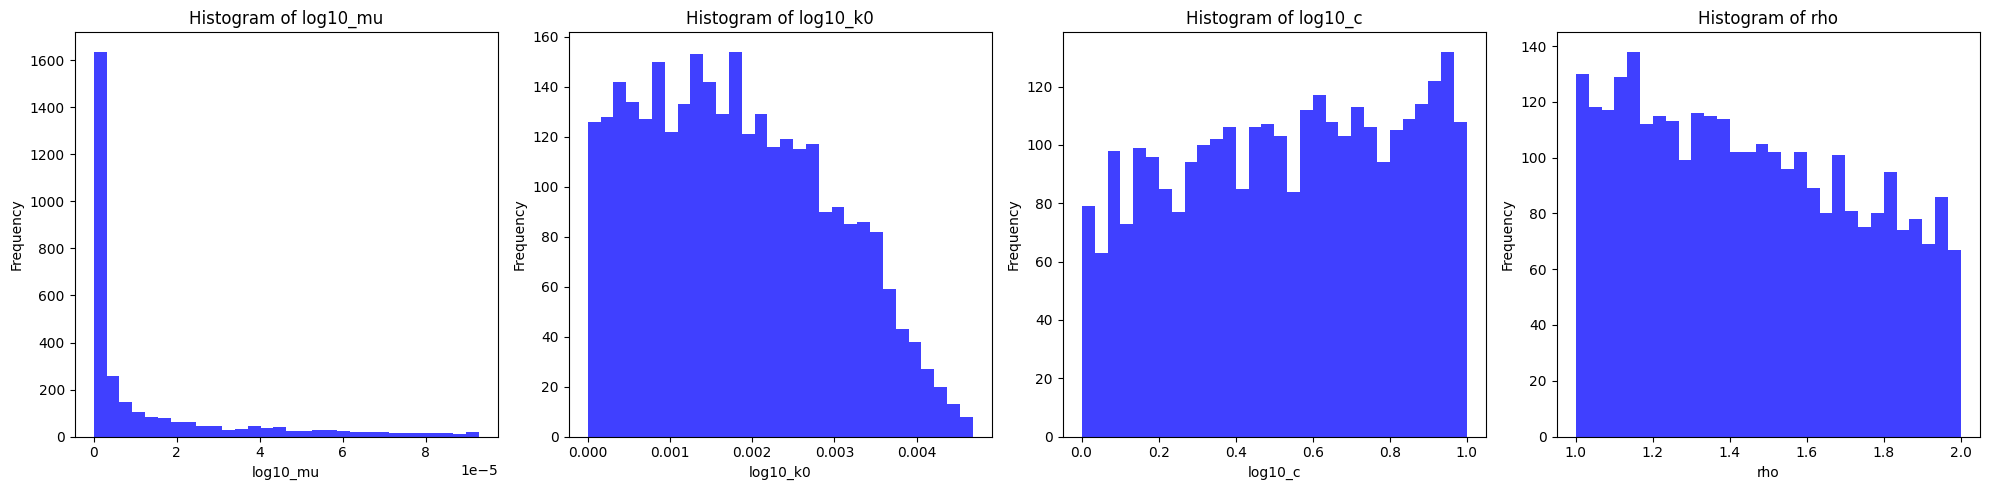

In [ ]:
import matplotlib.pyplot as plt

# Plot histograms for each parameter in thetas_all
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

theta_labels = ["log10_mu", "log10_k0", "log10_c", "rho"]
for i, ax in enumerate(axes):
    ax.hist(thetas_all[:, i], bins=30, alpha=0.75, color="blue")
    ax.set_title(f"Histogram of {theta_labels[i]}")
    ax.set_xlabel(theta_labels[i])
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.savefig("../res/earthquake_4_param/histograms_theta.png")
plt.show()

In [579]:
x_sims_all.shape

(3000, 23)

In [ ]:
# plot histograms for each summary statistic in x_sims_all

for i in range(summary_dims):
    plt.hist(x_sims_all[:, i], bins=30, alpha=0.75, color="blue")
    # plt.set_title(f'Histogram of summary stat {i}')
    # plt.set_xlabel(f'Summary stat {i}')
    # plt.set_ylabel('Frequency')
    plt.plot(x_obs[i], 0, "ro")
    plt.savefig(f"../res/earthquake_4_param/histogram_summary_{i}.png")
    plt.clf()

plt.tight_layout()
plt.savefig("../res/earthquake_4_param/histograms_summary.png")
plt.show()

<Figure size 640x480 with 0 Axes>

In [581]:
summary_dims = x_sims_all_standardised.shape[1]
x_sims_all.shape

(3000, 23)

In [ ]:
rng_key = random.PRNGKey(1)
rng_key, sub_key = random.split(rng_key)
flow = CouplingFlow(
    key=sub_key,
    base_dist=StandardNormal((summary_dims,)),
    transformer=RationalQuadraticSpline(
        knots=10, interval=5
    ),  # 10 spline segments over [-5, 5].
    cond_dim=thetas_all_standardised.shape[1],
    flow_layers=5,
    nn_width=50,
)

rng_key, sub_key = random.split(rng_key)
flow, losses = fit_to_data(
    key=sub_key,
    dist=flow,
    x=x_sims_all_standardised,
    condition=thetas_all_standardised,
    max_epochs=500,
    max_patience=20,
    batch_size=128,  #  TODO! CHANGE BACK 256
)

 61%|██████    | 305/500 [01:20<00:51,  3.81it/s, train=-58.5, val=-57.3 (Max patience reached)]


MCMC 

In [ ]:
from rsnl.model import get_robust_model
from numpyro.infer.initialization import (
    init_to_mean,
    init_to_median,
    init_to_sample,
    init_to_value,
)

In [ ]:
import json


def valid_fn(thetas):
    with open("../data/config/SCEDC_30.json", "r") as f:
        simulation_config = json.load(f)
    catalog_params = simulation_config["theta_0"].copy()
    if len(thetas) == 5:
        mu, a, k0, c, rho = thetas
    if len(thetas) == 4:
        mu, k0, c, rho = thetas
        a = simulation_config["beta"]
    eps = 1e-8
    try:
        params_dict = dict(
            {
                "log10_mu": np.log10(mu + eps),
                "log10_k0": np.log10(k0 + eps),
                "a": np.array(a),
                "log10_c": np.log10(c + eps),
                "rho": rho,
            }
        )  # Attempt conversion
        params_dict["a"] = params_dict["a"].item()
        params_dict["rho"] = params_dict["rho"].item()
    except Exception as e:
        print(e)

    catalog_params.update(params_dict)

    # shape_coords = "data/input_data/california_shape.npy"  # used to be simulation_config["shape_coords"]

    # np.random.seed(777)
    # Note: in four param model version, alpha ("a") fixed to beta
    if "a" not in catalog_params:
        catalog_params["a"] = simulation_config["beta"]

    if early_return(catalog_params, simulation_config["beta"]):
        return False
    else:
        return True

In [ ]:
def custom_init_to_valid_multiple_chains(prior, rng_key, num_samples=1, max_tries=5000):
    """Generate valid draws for multiple chains by repeatedly sampling from the prior."""
    thetas = []
    for _ in range(num_samples):
        for _ in range(max_tries):
            rng_key, subkey = random.split(rng_key)
            theta_candidate = np.array(prior.sample(subkey))
            if valid_fn(theta_candidate):
                thetas.append(theta_candidate)
                break
        else:
            raise RuntimeError(f"Could not find a valid draw in {max_tries} tries.")
    return jnp.array(thetas, dtype=jnp.float32)

In [ ]:
import jax.numpy as jnp
from numpyro.distributions import Uniform, Gamma, Independent, Distribution
from numpyro.distributions.util import clamp_probs
from numpyro.distributions import constraints


# Define the Gamma prior for mu
mu_prior = Gamma(concentration=0.1, rate=10.0)

# Define the Uniform priors for the remaining parameters
other_priors = Uniform(low=jnp.array([0.0, 0.0, 1.0]), high=jnp.array([1.0, 1.0, 2.0]))


# Combine the priors into a joint distribution
class CustomPrior(Distribution):
    support = constraints.real_vector

    def sample(self, key, sample_shape=()):
        mu_sample = mu_prior.sample(key, sample_shape)
        other_samples = other_priors.sample(key, sample_shape)
        return jnp.concatenate([mu_sample[..., None], other_samples], axis=-1)

    def log_prob(self, value):
        if value.ndim == 0:
            # Handle scalar case directly
            mu_log_prob = mu_prior.log_prob(value)
            other_log_prob = 0.0  # No other parameters to account for
        else:
            # Expected case for vector inputs
            mu_log_prob = mu_prior.log_prob(value[..., 0])
            other_log_prob = other_priors.log_prob(value[..., 1:])
            if len(other_log_prob.shape) > 1:
                other_log_prob = jnp.sum(other_log_prob, axis=-1)
        return mu_log_prob + other_log_prob


prior = CustomPrior()

In [ ]:
from typing import Optional

import jax.numpy as jnp
import numpyro  # type: ignore
import numpyro.distributions as dist  # type: ignore

from rsnl.utils import FlowNumpyro


def get_custom_robust_model(
    x_obs: jnp.ndarray,
    prior: dist.Distribution,
    flow: Optional[FlowNumpyro] = None,
    scale_adj_var: Optional[jnp.ndarray] = None,
    standardisation_params=None,
) -> jnp.ndarray:
    """Get robust numpyro model."""
    laplace_mean = jnp.zeros(len(x_obs))
    laplace_var = jnp.ones(len(x_obs))
    # if scale_adj_var is None:
    #     scale_adj_var = jnp.ones(len(x_obs))

    mu = numpyro.sample("mu", dist.Gamma(concentration=0.1, rate=10.0))
    print("mu: ", mu)
    # Then rescale to get the target range/mean
    c = numpyro.sample("c", dist.Uniform(0, 1))
    k0 = numpyro.sample("k0", dist.Uniform(0, 1))
    # mu = numpyro.deterministic("mu", 0.1 * mu_raw)
    rho = numpyro.sample("rho", dist.Uniform(1, 2))

    theta = jnp.array([mu, k0, c, rho])

    theta_standard = numpyro.deterministic(
        "theta_standard",
        (theta - standardisation_params["theta_mean"])
        / standardisation_params["theta_std"],
    )
    # print('theta_standard: ', theta_standard.shape)
    # Note: better sampling if use standard laplace then scale
    adj_params = numpyro.sample("adj_params", dist.Laplace(laplace_mean, laplace_var))
    scaled_adj_params = numpyro.deterministic(
        "adj_params_scaled", adj_params * scale_adj_var
    )
    x_adj = numpyro.deterministic("x_adj", x_obs - scaled_adj_params)
    # print("x_adj: ", x_adj.shape)
    if flow is not None:  # i.e. if not first round
        x_adj_sample = numpyro.sample(
            "x_adj_sample", FlowNumpyro(flow, theta=theta_standard), obs=x_adj
        )
    else:
        x_adj_sample = x_adj

    # print("x_adj_sample: ", x_adj_sample.shape)

    return x_adj_sample

In [588]:
x_obs_standard

Array([ 2.9119244e-01, -5.1620998e-03,  4.1330189e-01,  6.5015209e-01,
        7.1614403e-01,  7.5098926e-01,  9.6441472e-01,  1.2980970e+00,
        1.8444476e+00,  2.6397536e+00,  4.0495586e+00,  5.0462413e+00,
        5.8261280e+00,  7.5921612e+00,  7.5872765e+00,  8.6823912e+00,
        9.1035748e+00,  9.3610249e+00,  9.3089848e+00,  9.0381117e+00,
        8.7797041e+00,  8.5547028e+00,  8.3534765e+00], dtype=float32)

In [ ]:
model = get_custom_robust_model
target_accept_prob = 0.8
num_warmup = 1_000
num_sims_per_round = 1_000
thinning = 1
num_chains = 1
default_scale_adj_var = None
i = 1

# TODO: init from previous round
rng_key, sub_key = random.split(rng_key)
num_samples = 5
test_thetas = custom_init_to_valid_multiple_chains(
    prior, rng_key, num_samples=num_samples
)
log_probs = []
for i in range(num_samples):
    theta_standard = (
        test_thetas[i, :] - standardisation_params["theta_mean"]
    ) / standardisation_params["theta_std"]
    log_prob = flow.log_prob(x_obs_standard, condition=theta_standard)
    log_probs.append(log_prob)
    # get args for max num_chains of log_probs
    top_indices = jnp.argsort(jnp.array(log_probs))[-num_chains:][::-1]
theta_inits = test_thetas[top_indices, :]
rng_key, sub_key = random.split(rng_key)
# adj_inits = (x_obs_standard / 0.3) + 0.1 * random.normal(sub_key, (num_chains, len(x_obs_standard)))
# normal_sample = jnp.array(random.normal(sub_key, (num_chains, len(x_obs_standard))))
# adj_inits = (normal_sample-x_obs_standard) / 0.3 * x_obs_standard
# (x_obs_standard)/(0.3 * x_obs_standard) =  adj_param
# x_obs_standard - normal(0, 1)  =  adj_param * 0.3 * x_obs_standard
scale_adj_var = 0.3 * jnp.abs(x_obs_standard)
threshold = 5.0  # or any scale you find suitable
mask = jnp.abs(x_obs_standard) > threshold
adj_inits = jnp.where(
    mask, x_obs_standard / scale_adj_var, 0.0  # large offset for big obs
)
noise = 0.01 * random.normal(sub_key, (num_chains, summary_dims))  # e.g. 10% jitter
adj_inits = adj_inits.reshape((1, -1)) + noise

if num_chains > 1:
    init_values_list = []
    for i in range(num_chains):
        init_values_list.append(
            {
                "mu": theta_inits[i, 0],
                "k0": theta_inits[i, 1],
                "c": theta_inits[i, 2],
                "rho": theta_inits[i, 3],
                "adj_params": adj_inits[i],  # Ensure adj_inits is per chain
            }
        )
else:
    # For a single chain, provide a flat dictionary instead of a list
    init_values_list = {
        "mu": theta_inits[0, 0],
        "k0": theta_inits[0, 1],
        "c": theta_inits[0, 2],
        "rho": theta_inits[0, 3],
        "adj_params": adj_inits[0],  # adj_inits[0] for single chain
    }

for i in range(num_chains):
    theta_i = theta_inits[i, :]
    theta_i_standard = (
        theta_i - standardisation_params["theta_mean"]
    ) / standardisation_params["theta_std"]
    print("prob: ", flow.log_prob(x_obs_standard, theta_i_standard))


def debug_init_strategy(rng_key, shape=(), transformed=True):
    init_dict = init_to_value(values=init_values)(rng_key, shape, transformed)
    print("DEBUG init dict:\n", init_dict)
    return init_dict


init_strat = init_to_value(values=init_values_list)


nuts_kernel = NUTS(
    model,
    target_accept_prob=target_accept_prob,
    init_strategy=init_strat,
    #    dense_mass=True,
    #    max_tree_depth=10
)
mcmc = MCMC(
    nuts_kernel,
    num_warmup=num_warmup,
    num_samples=round((num_sims_per_round * thinning) / num_chains),
    thinning=thinning,
    num_chains=num_chains,
)

rng_key, sub_key1, sub_key2 = random.split(rng_key, 3)
if default_scale_adj_var is None:  # NOTE: i.e. this is the default behaviour
    if i == 0:
        scale_adj_var = jnp.ones(len(x_obs_standard))
    else:
        scale_adj_var_x_obs = 0.3
        scale_adj_var = scale_adj_var_x_obs * jnp.abs(x_obs_standard)
else:
    scale_adj_var = default_scale_adj_var
# prior = None
mcmc.run(
    sub_key1,
    x_obs_standard,
    prior,
    flow=flow,
    scale_adj_var=scale_adj_var,
    standardisation_params=standardisation_params,
    # init_params=init_values
)
mcmc.print_summary(exclude_deterministic=False)

prob:  -436.75388
mu:  3.7949987e-05
mu:  3.7949987e-05
mu:  Traced<ConcreteArray(3.794999429374002e-05, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = Array(3.7949994e-05, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x533deb610>, in_tracers=(Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>, Traced<ConcreteArray(3.794999429374002e-05, dtype=float32):JaxprTrace(level=1/0)>), out_tracer_refs=[<weakref at 0x58b687290; to 'JaxprTracer' at 0x3331e1bc0>], out_avals=[ShapedArray(float32[])], primitive=pjit, params={'jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = mul a b in (c,) }, 'in_shardings': (UnspecifiedValue, UnspecifiedValue), 'out_shardings': (UnspecifiedValue,), 'resource_env': None, 'donated_invars': (False, False), 'name': '<lambda>', 'keep_unused': False, 'inline': True}, effects=set(), source_info=SourceInfo(traceback=<jaxli

  0%|          | 0/2000 [00:00<?, ?it/s]

mu:  Traced<ShapedArray(float32[])>with<JVPTrace(level=5/0)> with
  primal = Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=3/0)>
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=4/0)> with
    pval = (ShapedArray(float32[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x5ace256c0>, in_tracers=(Traced<ShapedArray(float32[]):JaxprTrace(level=4/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=4/0)>), out_tracer_refs=[<weakref at 0x333102f70; to 'JaxprTracer' at 0x333102840>], out_avals=[ShapedArray(float32[])], primitive=pjit, params={'jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = mul a b in (c,) }, 'in_shardings': (UnspecifiedValue, UnspecifiedValue), 'out_shardings': (UnspecifiedValue,), 'resource_env': None, 'donated_invars': (False, False), 'name': '<lambda>', 'keep_unused': False, 'inline': True}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x36b392330>, name_stack=NameStack(stack=(Transfo

sample: 100%|██████████| 2000/2000 [11:52<00:00,  2.81it/s, 1023 steps of size 8.39e-04. acc. prob=0.86]


mu:  Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)>

                           mean       std    median      5.0%     95.0%     n_eff     r_hat
        adj_params[0]      0.94      0.17      0.93      0.65      1.20     31.96      1.02
        adj_params[1]     -1.08      0.19     -1.10     -1.34     -0.76      8.94      1.21
        adj_params[2]     -0.78      0.17     -0.80     -1.02     -0.47      9.58      1.17
        adj_params[3]     -1.08      0.53     -1.13     -1.96     -0.27      9.32      1.19
        adj_params[4]     -0.04      0.07     -0.04     -0.15      0.08      9.08      1.34
        adj_params[5]      0.22      0.07      0.23      0.13      0.33     24.13      1.01
        adj_params[6]      0.30      0.16      0.31      0.06      0.52     48.28      1.05
        adj_params[7]      0.58      0.37      0.77     -0.08      0.89     17.67      1.14
        adj_params[8]      0.29      0.95      0.18     -0.84      1.44     10.62      1.09
        a

In [590]:
init_values_list

{'mu': Array(3.7949987e-05, dtype=float32),
 'k0': Array(0.00302863, dtype=float32),
 'c': Array(0.13026023, dtype=float32),
 'rho': Array(1.0333457, dtype=float32),
 'adj_params': Array([ 4.4607008e-03, -1.2613242e-03, -5.1296121e-03, -7.8044093e-04,
         5.6300238e-03,  2.4247593e-03,  1.6236806e-03, -3.2232453e-03,
        -7.2358702e-03, -7.0313667e-03, -4.3855556e-03,  3.3325963e+00,
         3.3340001e+00,  3.3256867e+00,  3.3435576e+00,  3.3338878e+00,
         3.3336682e+00,  3.3222432e+00,  3.3418882e+00,  3.3317003e+00,
         3.3368492e+00,  3.3329282e+00,  3.3421574e+00], dtype=float32)}

In [591]:
mcmc.get_extra_fields().keys()
# print("Accept probs:", accept_probs)

dict_keys(['diverging'])

In [592]:
mcmc.print_summary(exclude_deterministic=False)


                           mean       std    median      5.0%     95.0%     n_eff     r_hat
        adj_params[0]      0.94      0.17      0.93      0.65      1.20     31.96      1.02
        adj_params[1]     -1.08      0.19     -1.10     -1.34     -0.76      8.94      1.21
        adj_params[2]     -0.78      0.17     -0.80     -1.02     -0.47      9.58      1.17
        adj_params[3]     -1.08      0.53     -1.13     -1.96     -0.27      9.32      1.19
        adj_params[4]     -0.04      0.07     -0.04     -0.15      0.08      9.08      1.34
        adj_params[5]      0.22      0.07      0.23      0.13      0.33     24.13      1.01
        adj_params[6]      0.30      0.16      0.31      0.06      0.52     48.28      1.05
        adj_params[7]      0.58      0.37      0.77     -0.08      0.89     17.67      1.14
        adj_params[8]      0.29      0.95      0.18     -0.84      1.44     10.62      1.09
        adj_params[9]      0.76      0.76      0.78     -0.31      2.38     18.

mu:  8.5183e-06
mu:  Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>


array([[<Axes: title={'center': 'c'}>, <Axes: title={'center': 'c'}>]],
      dtype=object)

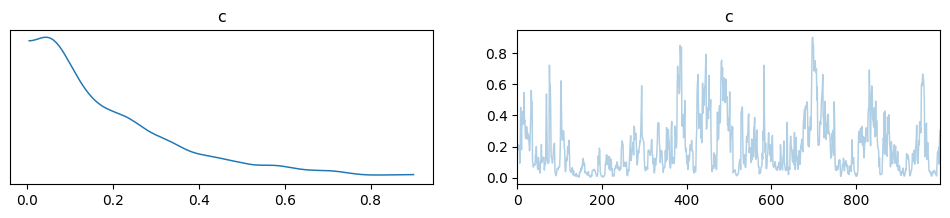

In [ ]:
import arviz as az

inference_data = az.from_numpyro(mcmc)
az.plot_trace(inference_data, var_names=["c"], compact=True)

array([[<Axes: ylabel='k0'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='c'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='mu', ylabel='rho'>, <Axes: xlabel='k0'>,
        <Axes: xlabel='c'>]], dtype=object)

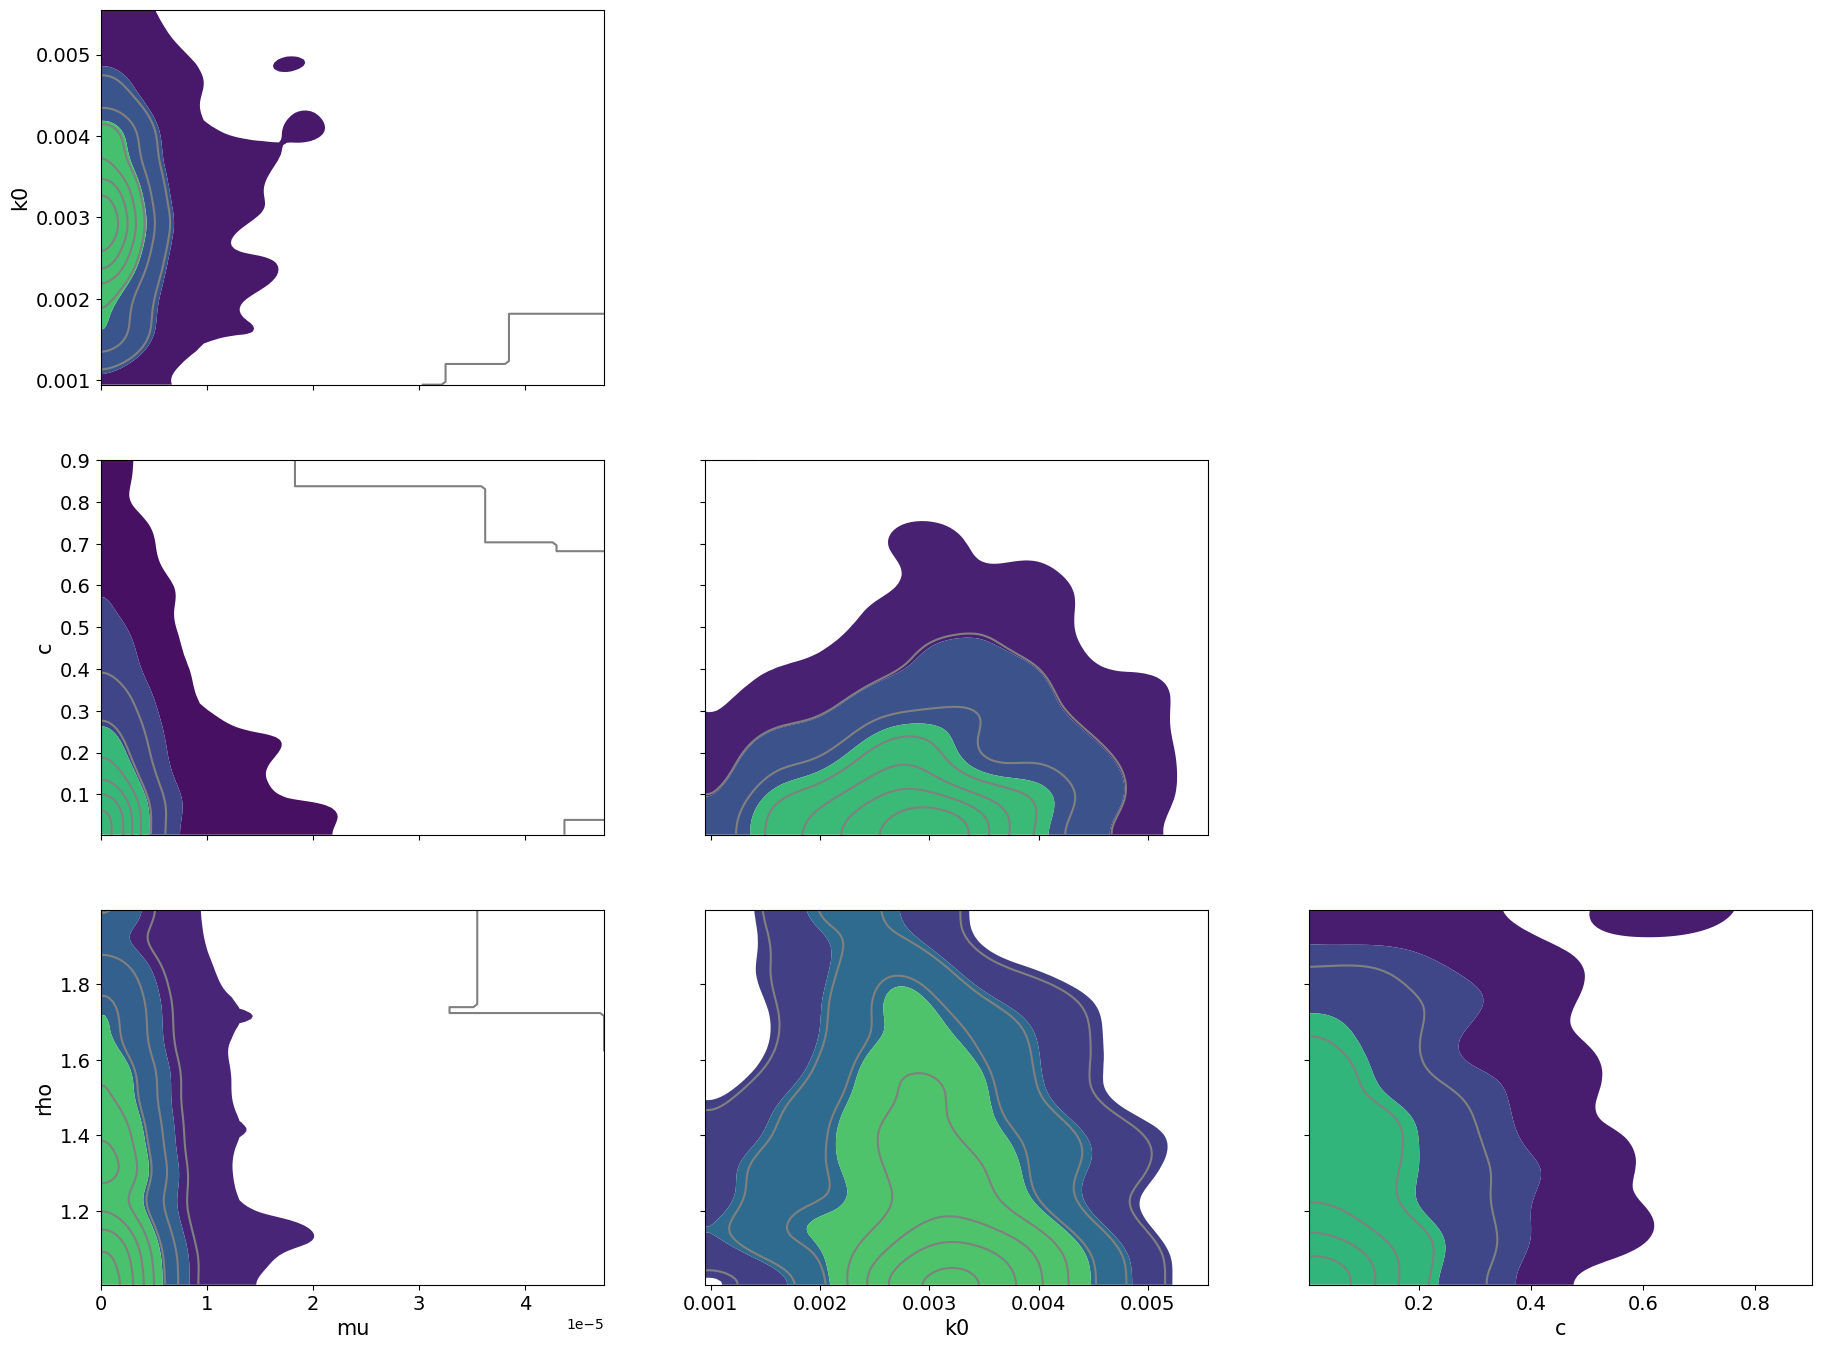

In [ ]:
# do bivariate scatter plots for inference_data
param_names = ["mu", "k0", "c", "rho"]
az.plot_pair(inference_data, var_names=param_names, kind="kde", divergences=True)